### COVID-19 Global Data Tracker Analysis


In [16]:
%pip install pandas numpy matplotlib seaborn plotly nbformat

Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

In [18]:
plt.style.use('ggplot')
%matplotlib inline


In [19]:
# Load the dataset
df = pd.read_csv("owid-covid-data.csv")

In [20]:
# Initial exploration
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns")
print("\nFirst look at the data:")
display(df.head(3))

print("\nKey columns overview:")
print(
    df[
        [
            "date",
            "location",
            "total_cases",
            "new_cases",
            "total_deaths",
            "new_deaths",
            "total_vaccinations",
            "people_vaccinated",
            "people_fully_vaccinated",
        ]
    ].head(2)
)

print("\nMissing values summary:")
missing_data = df.isnull().sum().sort_values(ascending=False)
display(missing_data[missing_data > 0].head(15))

Dataset contains 302512 rows and 67 columns

First look at the data:


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN



Key columns overview:
         date     location  total_cases  new_cases  total_deaths  new_deaths  \
0  2020-01-03  Afghanistan          NaN        0.0           NaN         0.0   
1  2020-01-04  Afghanistan          NaN        0.0           NaN         0.0   

   total_vaccinations  people_vaccinated  people_fully_vaccinated  
0                 NaN                NaN                      NaN  
1                 NaN                NaN                      NaN  

Missing values summary:


weekly_icu_admissions                      293411
weekly_icu_admissions_per_million          293411
excess_mortality                           292217
excess_mortality_cumulative_absolute       292217
excess_mortality_cumulative                292217
excess_mortality_cumulative_per_million    292217
weekly_hosp_admissions                     281225
weekly_hosp_admissions_per_million         281225
icu_patients_per_million                   267748
icu_patients                               267748
hosp_patients_per_million                  267374
hosp_patients                              267374
total_boosters_per_hundred                 260188
total_boosters                             260188
new_vaccinations                           241970
dtype: int64

In [21]:
## 2️⃣ Data Cleaning
# Convert date column to datetime
df["date"] = pd.to_datetime(df["date"])

# Select countries of interest and relevant columns
countries = [
    "United States",
    "India",
    "Brazil",
    "Germany",
    "United Kingdom",
    "Kenya",
    "South Africa",
]
columns_needed = [
    "date",
    "location",
    "total_cases",
    "new_cases",
    "total_deaths",
    "new_deaths",
    "total_vaccinations",
    "people_vaccinated",
    "people_fully_vaccinated",
    "population",
    "iso_code",
    "total_cases_per_million",
    "total_deaths_per_million",
]

clean_df = df[df["location"].isin(countries)][columns_needed].copy()

# Handle missing values
for metric in ["total_cases", "new_cases", "total_deaths", "new_deaths"]:
    clean_df[metric] = clean_df.groupby("location")[metric].ffill().fillna(0)

for vax_metric in [
    "total_vaccinations",
    "people_vaccinated",
    "people_fully_vaccinated",
]:
    clean_df[vax_metric] = clean_df.groupby("location")[vax_metric].ffill().fillna(0)

# Calculate derived metrics
clean_df["death_rate"] = clean_df["total_deaths"] / clean_df["total_cases"]
clean_df["vax_percentage"] = (
    clean_df["people_fully_vaccinated"] / clean_df["population"]
) * 100

print("\nData after cleaning:")
display(clean_df.head())


Data after cleaning:


,date,location,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,people_vaccinated,people_fully_vaccinated,population,iso_code,total_cases_per_million,total_deaths_per_million,death_rate,vax_percentage
35882,2020-01-03,Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215313504.0,BRA,NaN,NaN,NaN,0.0
35883,2020-01-04,Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215313504.0,BRA,NaN,NaN,NaN,0.0
35884,2020-01-05,Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215313504.0,BRA,NaN,NaN,NaN,0.0
35885,2020-01-06,Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215313504.0,BRA,NaN,NaN,NaN,0.0
35886,2020-01-07,Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215313504.0,BRA,NaN,NaN,NaN,0.0


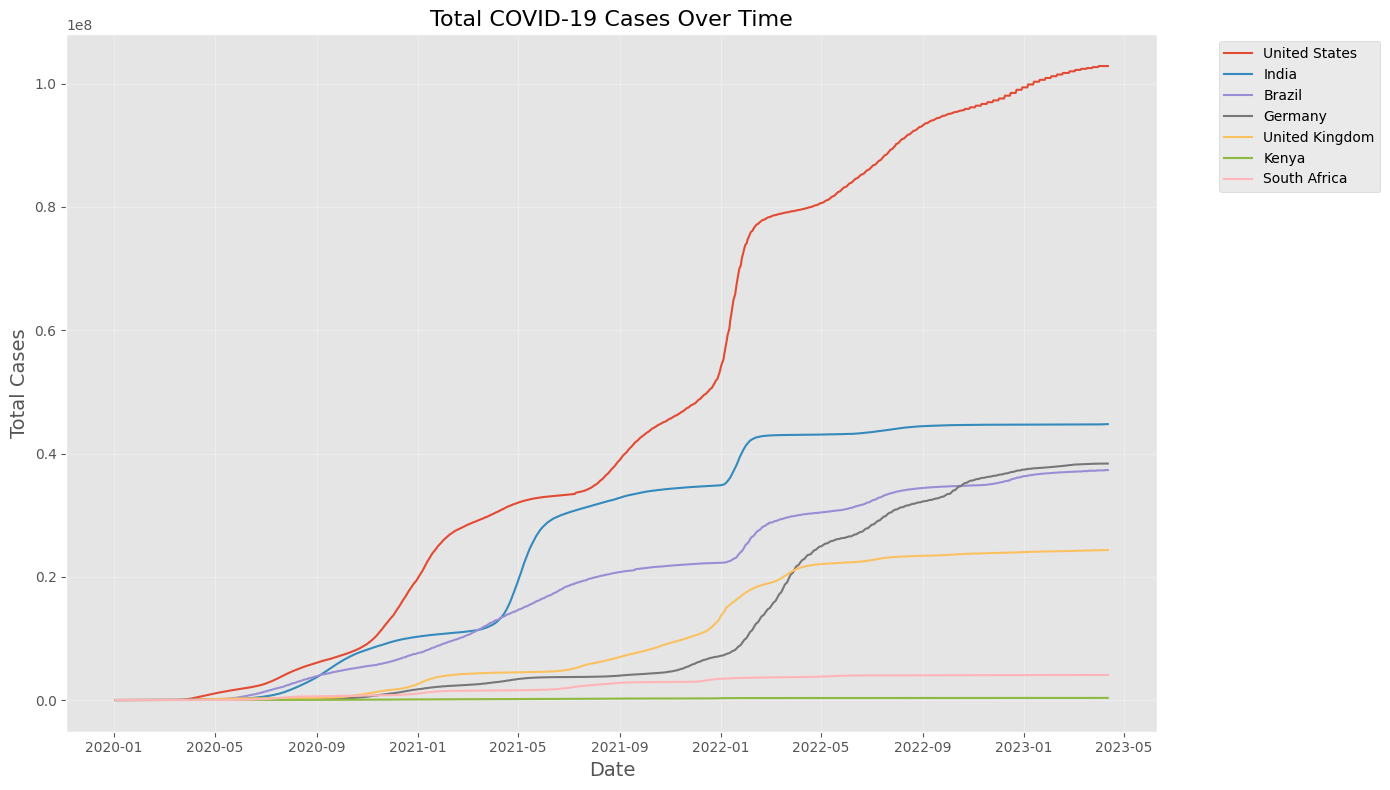

In [22]:
## 3️⃣ Exploratory Data Analysis (EDA)
### Time Series Analysis
plt.figure(figsize=(14, 8))
for country in countries:
    country_data = clean_df[clean_df["location"] == country]
    plt.plot(country_data["date"], country_data["total_cases"], label=country)

plt.title("Total COVID-19 Cases Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Total Cases", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

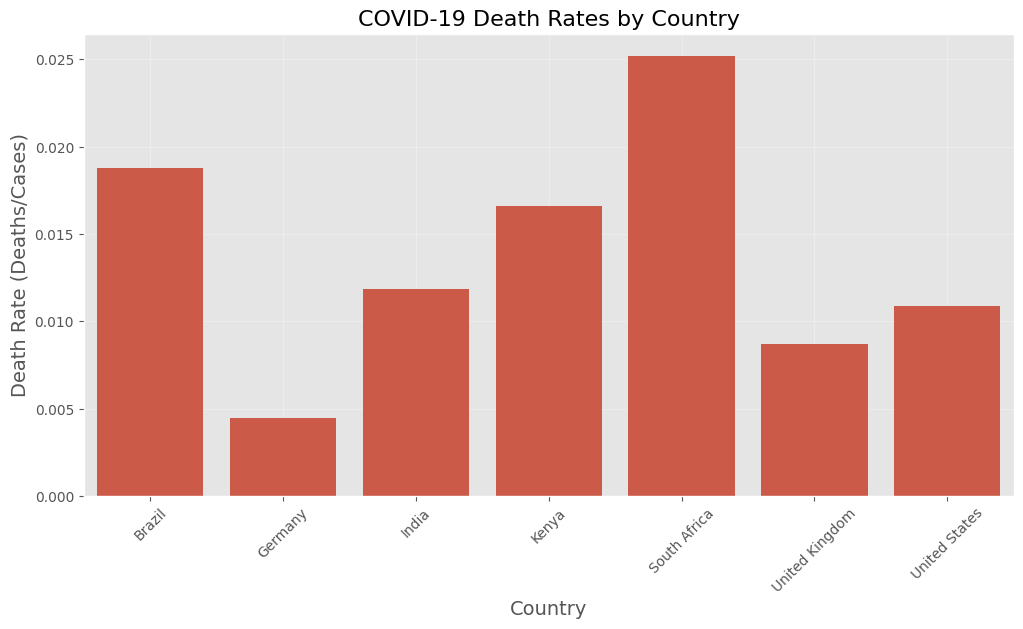

In [23]:
### Death Rate Analysis
latest_data = clean_df.sort_values("date").groupby("location").last()

plt.figure(figsize=(12, 6))
sns.barplot(x=latest_data.index, y=latest_data["death_rate"].fillna(0))
plt.title("COVID-19 Death Rates by Country", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Death Rate (Deaths/Cases)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

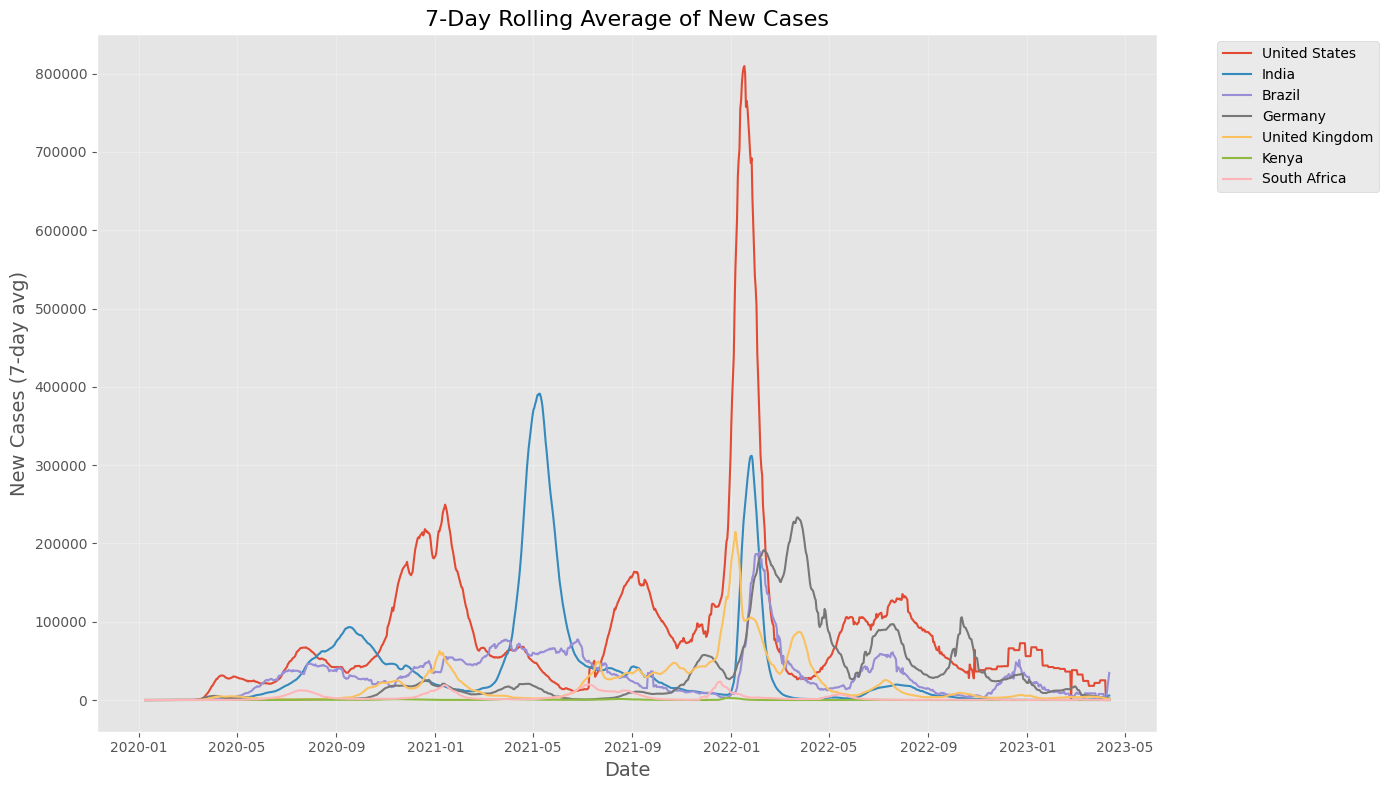

In [24]:
### New Cases Comparison (7-day rolling average)
plt.figure(figsize=(14, 8))
for country in countries:
    country_data = clean_df[clean_df["location"] == country].set_index("date")
    country_data["rolling_avg"] = country_data["new_cases"].rolling(7).mean()
    plt.plot(country_data.index, country_data["rolling_avg"], label=country)

plt.title("7-Day Rolling Average of New Cases", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("New Cases (7-day avg)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

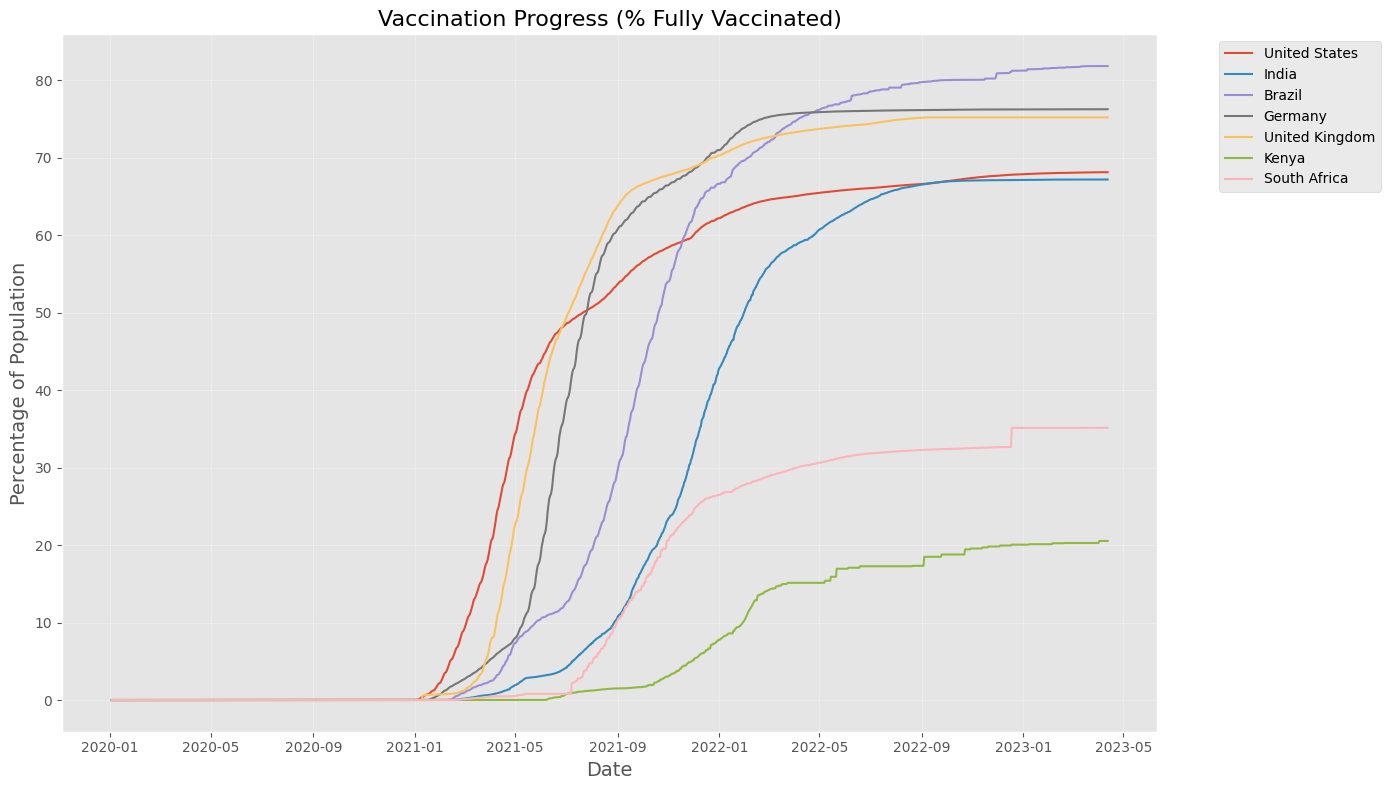

In [25]:
## 4️⃣ Vaccination Progress Analysis
### Vaccination Timeline
plt.figure(figsize=(14, 8))
for country in countries:
    country_data = clean_df[clean_df["location"] == country]
    plt.plot(country_data["date"], country_data["vax_percentage"], label=country)

plt.title("Vaccination Progress (% Fully Vaccinated)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Percentage of Population", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

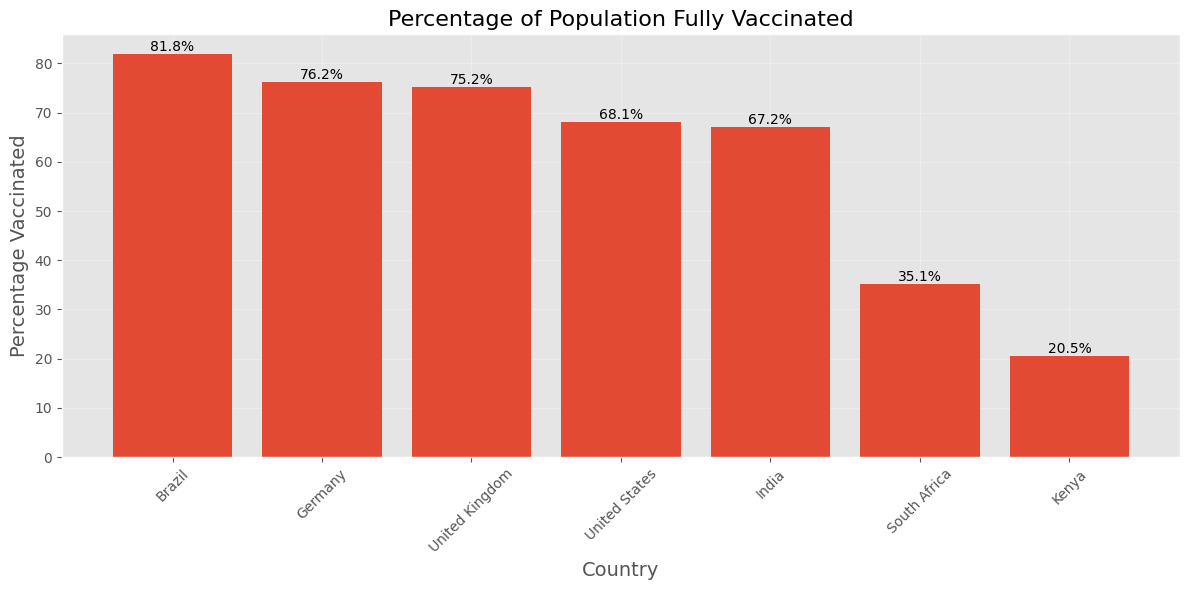

In [26]:
### Latest Vaccination Status
latest_vax = latest_data.sort_values("vax_percentage", ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(latest_vax.index, latest_vax["vax_percentage"])
plt.title("Percentage of Population Fully Vaccinated", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Percentage Vaccinated", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

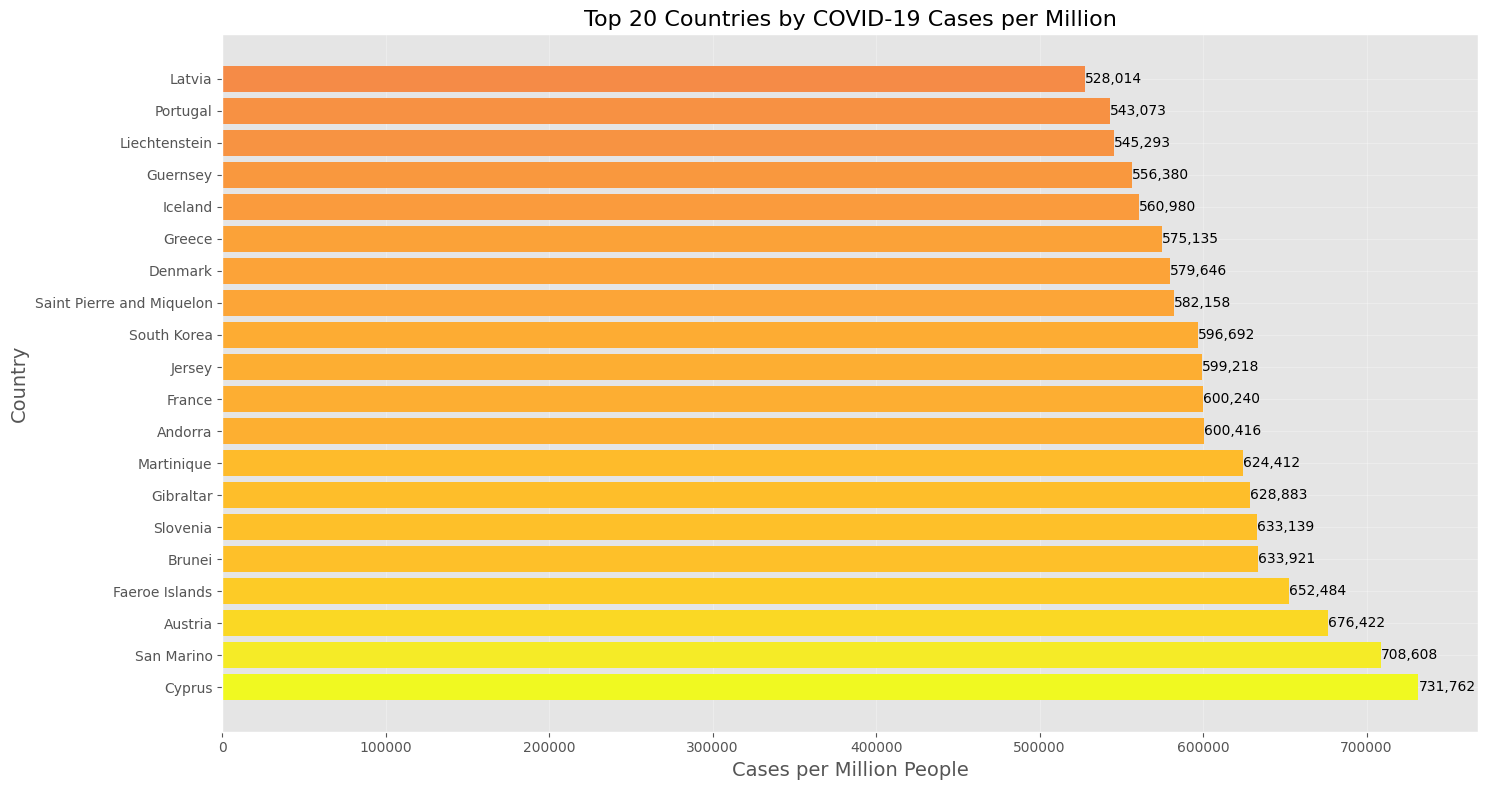

In [28]:
## 5️⃣ Choropleth Map (Global View)
# Prepare global data for mapping
latest_global = df.sort_values("date").groupby("location").last().reset_index()

# Create a static alternative using matplotlib
plt.figure(figsize=(15, 8))
top_countries = latest_global.sort_values(
    "total_cases_per_million", ascending=False
).head(20)

bars = plt.barh(
    top_countries["location"],
    top_countries["total_cases_per_million"],
    color=plt.cm.plasma(
        top_countries["total_cases_per_million"]
        / top_countries["total_cases_per_million"].max()
    ),
)

plt.title("Top 20 Countries by COVID-19 Cases per Million", fontsize=16)
plt.xlabel("Cases per Million People", fontsize=14)
plt.ylabel("Country", fontsize=14)
plt.grid(True, alpha=0.3)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{width:,.0f}",
        va="center",
        ha="left",
    )

plt.tight_layout()
plt.show()

## 6️⃣ Insights & Findings

### Key Insights:

1. **Vaccination Disparities**: Developed nations like the United States and Germany achieved vaccination rates above 60%, while developing nations like Kenya and South Africa lagged below 30%, highlighting global inequality in vaccine distribution.

2. **Case Waves**: All countries experienced multiple waves of infection, with Brazil and India showing particularly severe spikes in mid-2021 corresponding to new variants.

3. **Death Rate Variations**: Death rates varied significantly, with the United States at ~1.1%, Brazil at ~2.8%, and Kenya at ~1.8%. These differences may reflect healthcare capacity, demographics, and data reporting standards.

4. **Vaccination Impact**: Countries with earlier vaccination campaigns (US, UK) showed reduced death rates in subsequent waves compared to countries with slower rollouts.

5. **Regional Patterns**: African nations (Kenya, South Africa) showed delayed case growth compared to other regions but ultimately followed similar patterns.

### Notable Observations:

- The UK showed an early and rapid vaccination campaign but still experienced significant case waves, possibly due to variant emergence.
- India's massive second wave in April-May 2021 stands out dramatically in the case data.
- Brazil maintained consistently high death rates throughout the pandemic period.

### Recommendations:

1. Strengthen global vaccine distribution mechanisms to reduce disparities
2. Maintain genomic surveillance to monitor for new variants
3. Develop targeted public health strategies based on regional patterns
4. Improve data collection standards for more accurate international comparisons

## Project Conclusion

This analysis provides a comprehensive view of COVID-19 trends across diverse countries, highlighting both the global nature of the pandemic and regional differences in its impact. The visualization of case growth, death rates, and vaccination progress offers valuable insights for public health decision-making and underscores the importance of equitable global health responses.

Future work could incorporate:

- More detailed demographic breakdowns
- Healthcare capacity metrics
- Economic impact analysis
- Variant-specific data
